<a href="https://colab.research.google.com/github/Supriyo-ux/LLM_NLP_REG/blob/main/Llama__2_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3 Common Ways To Improve Your Large Language Model**
*Easy tips for fine-tuning the output of any LLM*
<br>
<div>

<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/f4fd15ca-dd59-41f5-8a9f-a70d18879051" width="750"/>
</div>


In [ ]:
!pip install huggingface-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 4.4 MB/s eta 0:00:00


# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00


In [ ]:
%%capture
!pip install transformers datasets accelerate bitsandbytes xformers langchain sentence_transformers autotrain-advanced faiss-gpu

In [ ]:
from torch import cuda, bfloat16
import transformers

We will go through 3 common ways to improve Llama 2, or any LLM:

<br>
<div>
<img src="https://cdn-images-1.medium.com/v2/resize:fit:1200/1*LkwzNFU5yOxOQF0D_nl3mQ.png" width="750"/>
</div>

In practice, each of these 3 methods can be run either indepedently but we can even combine them:
<!--
<br>
<div>
<img src="https://cdn-images-1.medium.com/v2/resize:fit:1800/1*kKj5u6L0zHeXtF_HLL-NyQ.png" width="1200"/>
</div>
 -->


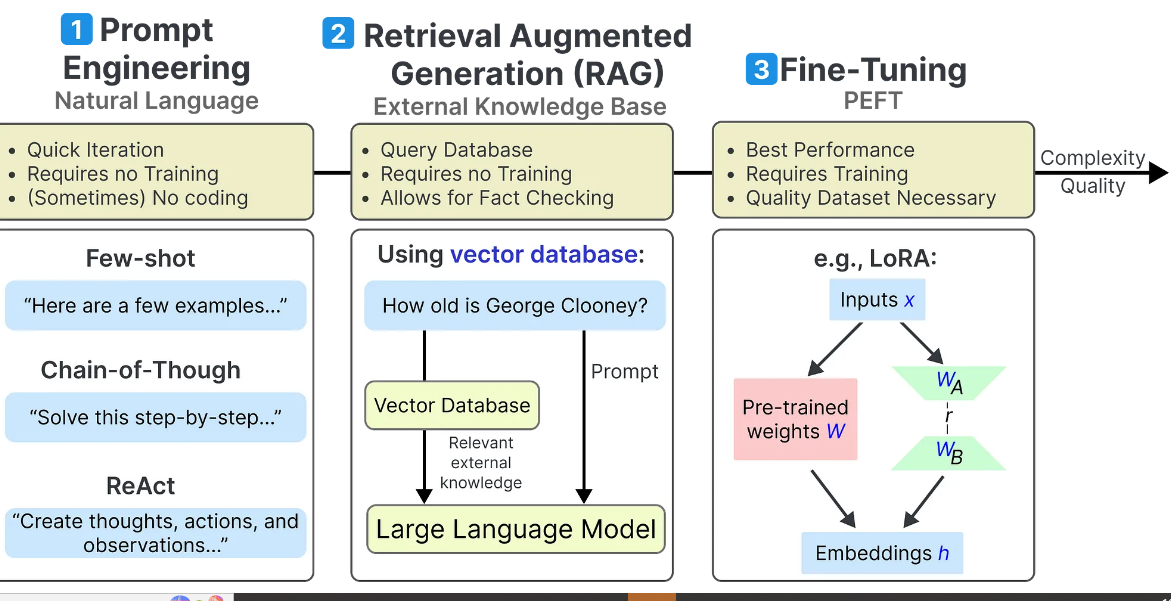

# 🦙 **Llama 2**

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-13b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [ ]:
model_id = 'meta-llama/Llama-2-13b-chat-hf'

In [ ]:
# 4-bit Quanityzation to load Llama 2 with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Most open-source LLMs have some sort of template that you must adhere to when creating prompts. In the case of Llama 2, the following helps guide the prompts:

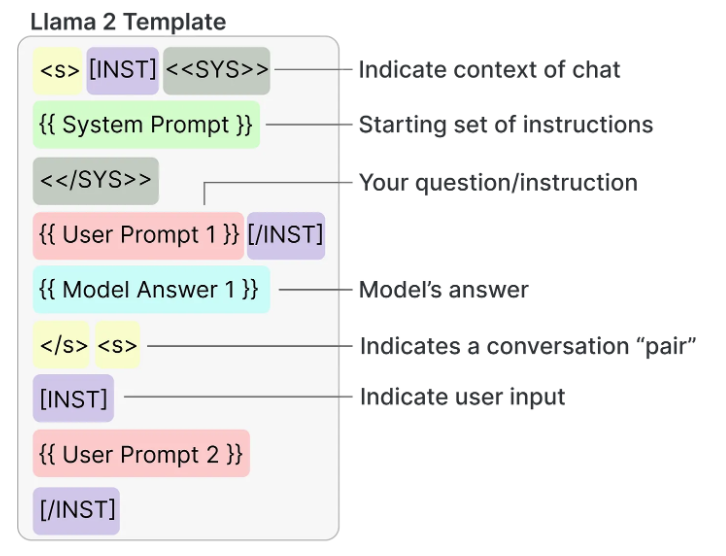

This means that we would have to use the prompt as follows to generate text properly:

In [ ]:
basic_prompt = """
<s>[INST] <<SYS>>

You are a helpful assistant

<</SYS>>

What is 3 * 2? [/INST]
"""
print(generator(basic_prompt)[0]["generated_text"])


<s>[INST] <<SYS>>

You are a helpful assistant

<</SYS>>

What is 3 * 2? [/INST]

Hello! I'd be happy to help you with that calculation. 3 * 2 is equal to 6!


1. Prompt Engineering ⚙️
How we ask the LLM something has a major effect on the quality of the output that we get. We need to be precise, complete and give examples of the output we are interested in.

This tailoring of your prompt is called prompt engineering.

Prompt engineering is such an amazing way to “tune” your model. It requires no updating of the model and you can quickly iterate over it.

There are two major concepts in prompt engineering:

Example-based
Thought-based
Example-based Prompt Engineering
In example-based prompting, such as one-shot or few-shot learning, we provide the LLM with a couple of examples of what we are looking for.

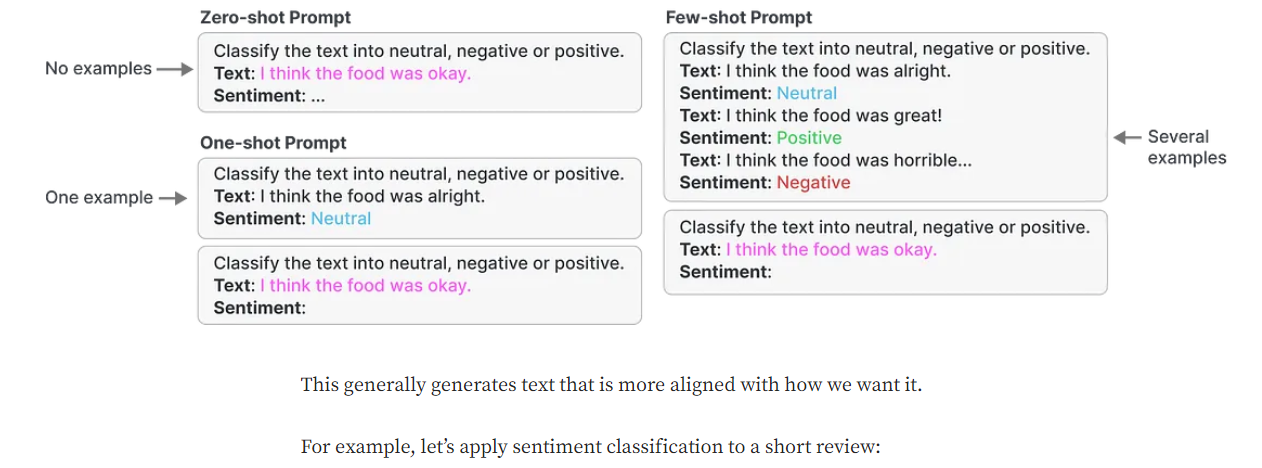

In [ ]:
prompt = """
<s>[INST] <<SYS>>

You are a helpful assistant.

<</SYS>>

Classify the text into neutral, negative or positive.
Text: I think the food was good. [/INST]
"""
print(generator(prompt)[0]["generated_text"])


<s>[INST] <<SYS>>

You are a helpful assistant.

<</SYS>>

Classify the text into neutral, negative or positive. 
Text: I think the food was good. [/INST]

Positive.


Personally, I am not that convinced with the answer. I think it is more neutral than positive. Also, we have to search in the text for the answer.

Instead, let’s give it an example of how we want the answer to be generated:

In [ ]:
prompt = """
<s>[INST] <<SYS>>

You are a helpful assistant.

<</SYS>>

Classify the text into neutral, negative or positive.
Text: I think the food was alright.
Sentiment:
[/INST]

Neutral</s><s>

[INST]
Classify the text into neutral, negative or positive.
Text: I think the food was okay.
Sentiment:
[/INST]
"""
print(generator(prompt)[0]["generated_text"])


<s>[INST] <<SYS>>

You are a helpful assistant.

<</SYS>>

Classify the text into neutral, negative or positive. 
Text: I think the food was alright.
Sentiment: 
[/INST] 

Neutral</s><s>

[INST]
Classify the text into neutral, negative or positive. 
Text: I think the food was okay.
Sentiment: 
[/INST] 

Neutral


Now, the LLM is to the point and gives only the answer that we are interested in. Much better!

Thought-based Prompt Engineering
We can go a step further and ask the LLM to “reason” about its answer.

By having the LLM divide its thinking into smaller steps, it allows for more computation to be given to each step. These smaller steps are generally referred to as the “thoughts” of the LLM.

There are many ways that we can use thought-based prompting and we can make it quite complex as seen below:

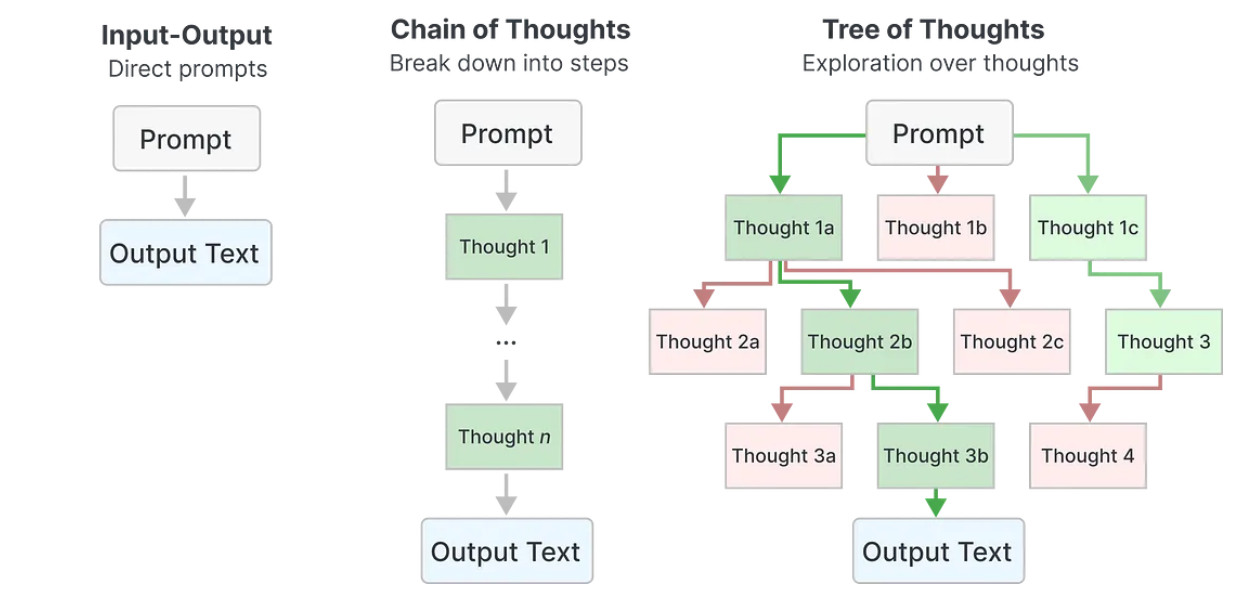

However, let’s start with the most basic example. What if we ask the model to solve a problem by breaking the problem into steps?

In [ ]:
prompt = """
<s>[INST] <<SYS>>

You are a helpful assistant.

<</SYS>>

Do the odd numbers in this group add up to an even number? 3, 5, 15, 32.
Solve by breaking the problem into steps.
Identify the odd numbers, add them, and indicate whether the result is odd or even.[/INST]
"""
print(generator(prompt)[0]["generated_text"])


<s>[INST] <<SYS>>

You are a helpful assistant.

<</SYS>>

Do the odd numbers in this group add up to an even number? 3, 5, 15, 32.
Solve by breaking the problem into steps. 
Identify the odd numbers, add them, and indicate whether the result is odd or even.[/INST]

Hello! I'd be happy to help you with that. Let's break down the problem into steps:

Step 1: Identify the odd numbers in the group.

The odd numbers in the group are:

3, 5, 15

Step 2: Add the odd numbers together.

3 + 5 + 15 = 23

Step 3: Is the result odd or even?

23 is an odd number.

Therefore, the sum of the odd numbers in the group is an odd number.


As we have seen before, this is also called Chain-of-Thought where the LLM has a sequence of individual thoughts or steps it follows.

These individual steps also help the model to stay accountable during its computation. Because it has “reasoned” about each step individually there is structure in its “thinking” process.

2. Retrieval-Augmented Generation (RAG) 🗃️
Although prompt engineering can get us an improvement, it cannot make the LLM know something it has not learned before.

When an LLM is trained in 2022, it has no knowledge about what has happened in 2023.

This is where Retrieval-Augmented Generation (RAG) comes in. It is a method of providing external knowledge to an LLM that it can leverage.

In RAG, a knowledge base, like Wikipedia, is converted to numerical representations to capture its meaning, called embeddings. These embeddings are stored in a vector database so that the information can easily be retrieved.



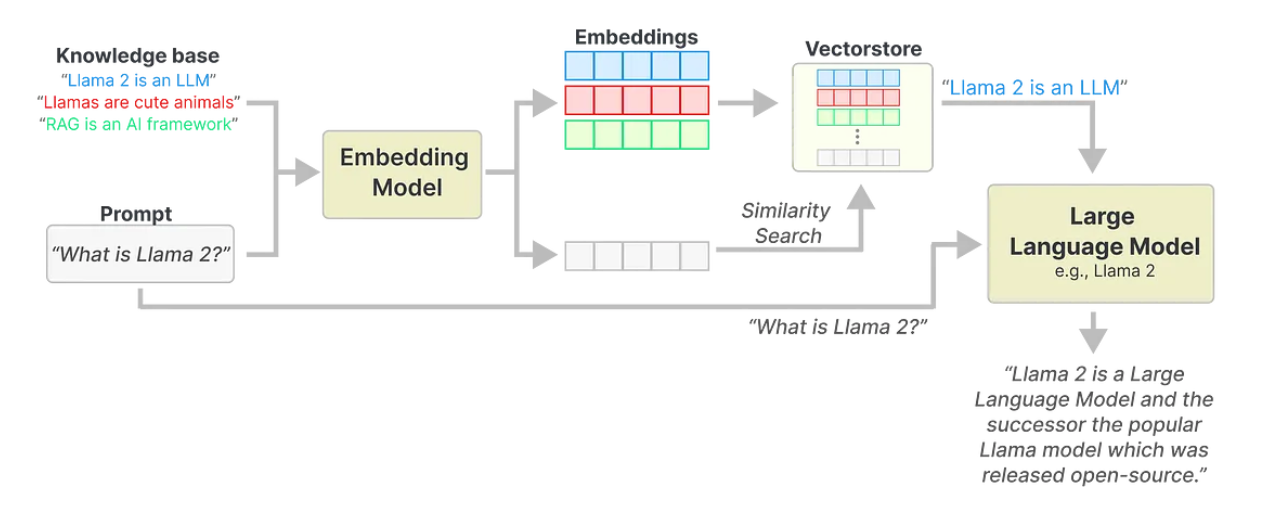

Then, when you give the LLM a certain prompt, the vector database is searched for information that relates to the prompt.

The most relevant information is then passed to the LLM as the additional context that it can use to derive its response.

In practice, RAG helps the LLM to “look up” information in its external knowledge base to improve its response.

Creating a RAG Pipeline with LangChain
To create an RAG pipeline or system, we can use the well-known and easy-to-use framework called LangChain.

We’ll start with creating a tiny knowledge base about Llama 2 and writing it into a text file:

In [ ]:
# Our tiny knowledge base
knowledge_base = [
    "On July 18, 2023, in partnership with Microsoft, Meta announced LLaMA-2, the next generation of LLaMA." ,
    "Llama 2, a collection of pretrained and fine-tuned large language models (LLMs) ",
    "The fine-tuned LLMs, called Llama 2-Chat, are optimized for dialogue use cases.",
    "Meta trained and released LLaMA-2 in three model sizes: 7, 13, and 70 billion parameters.",
    "The model architecture remains largely unchanged from that of LLaMA-1 models, but 40% more data was used to train the foundational models.",
    "The accompanying preprint also mentions a model with 34B parameters that might be released in the future upon satisfying safety targets."
]
with open(r'RAG_knowledge_base.txt', 'w') as fp:
    fp.write('\n'.join(knowledge_base))

After doing so, we will need to create an embedding model that can convert text to numerical representations, namely embeddings.

We will choose a well-known sentence-transformers model, namely sentence-transformers/all-MiniLM-L6-v2.

In [ ]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# Embedding Model for converting text to numerical representations
embedding_model = HuggingFaceEmbeddings(
    model_name='sentence-transformers/all-MiniLM-L6-v2'
)

Now that we have an embedding model and a tiny knowledge base, we can start developing our vector database. There are many to choose from but let’s choose one that we can use locally, namely FAISS.

In [ ]:
import langchain
langchain.debug = True

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader

# Load documents and split them
documents = TextLoader("/content/RAG_knowledge_base.txt").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

# Create local vector database
db = FAISS.from_documents(docs, embedding_model)

In [ ]:
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline

# Load LLM into LangChain
llm = HuggingFacePipeline(pipeline=generator)

# RAG Pipeline
rag = RetrievalQA.from_chain_type(
    llm=llm, chain_type='stuff',
    retriever=db.as_retriever()
)

In [ ]:
llm('What is Llama 2?')

[llm/start] [1:llm:HuggingFacePipeline] Entering LLM run with input:
{
  "prompts": [
    "What is Llama 2?"
  ]
}
[llm/end] [1:llm:HuggingFacePipeline] [41.89s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\n\nLlama 2 is a cryptocurrency that was created as a parody of the popular cryptocurrency Dogecoin. It was designed to be a humorous and lighthearted alternative to more serious cryptocurrencies, and it quickly gained a following among cryptocurrency enthusiasts.\n\nLike Dogecoin, Llama 2 uses a decentralized blockchain network to facilitate transactions and manage its supply. However, unlike Dogecoin, Llama 2 has a much larger total supply of coins (100 billion) and a faster block time (1 minute). This makes it more suitable for fast and cheap transactions, but also means that it may be less stable and secure than more established cryptocurrencies like Bitcoin or Ethereum.\n\nOne of the key features of Llama 2 is its use of a \"llama-themed\" pr

'\n\nLlama 2 is a cryptocurrency that was created as a parody of the popular cryptocurrency Dogecoin. It was designed to be a humorous and lighthearted alternative to more serious cryptocurrencies, and it quickly gained a following among cryptocurrency enthusiasts.\n\nLike Dogecoin, Llama 2 uses a decentralized blockchain network to facilitate transactions and manage its supply. However, unlike Dogecoin, Llama 2 has a much larger total supply of coins (100 billion) and a faster block time (1 minute). This makes it more suitable for fast and cheap transactions, but also means that it may be less stable and secure than more established cryptocurrencies like Bitcoin or Ethereum.\n\nOne of the key features of Llama 2 is its use of a "llama-themed" proof-of-work algorithm, which requires miners to solve a complex mathematical puzzle in order to validate transactions and earn new coins. This puzzle is based on the famous "llama dance" meme, and it adds a playful and whimsical touch to the cr

Cryptocurrency? That is not exactly the answer that we were looking for… It seems that it has no knowledge about itself.

Let’s try to use the RAG pipeline instead:

In [ ]:
rag('What is Llama 2?')

{'query': 'What is Llama 2?',
 'result': ' Llama 2 is a collection of pretrained and fine-tuned large language models (LLMs) announced by Meta on July 18, 2023, in partnership with Microsoft.'}

#3. Parameter-Efficient Fine-Tuning 🛠️
Both prompt engineering and RAG generally do not change the LLM in itself. Its parameters remain the same and the model does not “learn” anything new, it simply leverages.

We can fine-tune the LLM for a specific use case with domain-specific data so that it learns something new.

Instead of fine-tuning the model’s billions of parameters, we can leverage PEFT instead, Parameter-Efficient Fine-Tuning. As the name implies, it is a subfield that focuses on efficiently fine-tuning an LLM with as few parameters as possible.

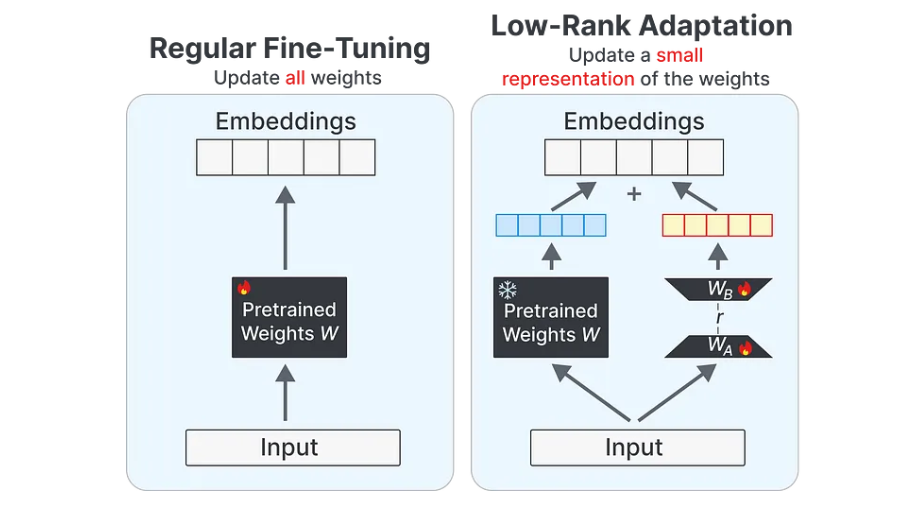


One of the most often used methods to do so is called Low-Rank Adaptation (LoRA). LoRA finds a small subset of the original parameters to train without having to touch the base model.

These parameters can be seen as smaller representations of the full model where only the most important or impactful parameters are trained. The beauty is that the resulting weights can be added to the base model and therefore saved separately.

Fine-Tuning Llama 2 with AutoTrain
The process of fine-tuning Llama 2 can be difficult with the many parameters out there. Fortunately, AutoTrain takes most of the difficulty away from you and allows you to fine-tune in only a single line!

We’ll start with the data. As always, it is the one thing that affects the resulting performance most!

We are going to make the base Llama 2 model, a chat model, and we will use the OpenAssistant Guanaco dataset for that:

In [ ]:
import pandas as pd
from datasets import load_dataset

# Load dataset in pandas
dataset = load_dataset("timdettmers/openassistant-guanaco")
df = pd.DataFrame(dataset["train"][:1000]).dropna()
df.to_csv("train.csv")

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(df["text"].iloc[1])

### Human: ¿CUales son las etapas del desarrollo y en qué consisten según Piaget?### Assistant: Jean Piaget fue un psicólogo suizo que propuso una teoría sobre el desarrollo cognitivo humano que consta de cuatro etapas:

Etapa sensoriomotora (0-2 años): Durante esta etapa, el niño aprende a través de sus sentidos y movimientos. Descubre que sus acciones pueden tener un impacto en el entorno y comienza a formarse una idea básica de objetividad y continuidad.

Etapa preoperatoria (2-7 años): En esta etapa, el niño comienza a desarrollar un pensamiento simbólico y a comprender que las cosas pueden representar a otras cosas. También comienzan a desarrollar un pensamiento lógico y a comprender conceptos como la causa y el efecto.

Etapa de operaciones concretas (7-12 años): Durante esta etapa, el niño desarrolla un pensamiento lógico y comprende las relaciones causales. Empiezan a comprender que las cosas pueden tener múltiples perspectivas y que los conceptos pueden ser más complejos de lo

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install diffusers==0.20.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.20.2-py3-none-any.whl size=1342633 sha256=ec62c49f7b71feb2e84a9d2b3043d24e0f0193d72af35ff53833a1a987066057
  Stored in directory: /root/.cache/pip/wheels/dc/8b/d9/34f7a1936109e05e9bba0cc2241a6f8cd89e25959dc7aae942
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.21.4
    Uninstalling diffusers-0.21.4:
      Successfully uninstalled diffusers-0.21.4


In [ ]:
from diffusers.utils.torch_utils import randn_tensor

In [ ]:
!autotrain llm --train \
--project_name Llama-Chat_prompt \
--model abhishek/llama-2-7b-hf-small-shards \
--data_path . \
--use_peft \
--use_int4 \
--learning_rate 2e-4 \
--num_train_epochs 1 \
--trainer sft \
--merge_adapter

> INFO    Running LLM
> INFO    Params: Namespace(version=False, train=True, deploy=False, inference=False, data_path='.', train_split='train', valid_split=None, text_column='text', model='abhishek/llama-2-7b-hf-small-shards', learning_rate=0.0002, num_train_epochs=1, train_batch_size=2, warmup_ratio=0.1, gradient_accumulation_steps=1, optimizer='adamw_torch', scheduler='linear', weight_decay=0.0, max_grad_norm=1.0, seed=42, add_eos_token=False, block_size=-1, use_peft=True, lora_r=16, lora_alpha=32, lora_dropout=0.05, logging_steps=-1, project_name='Llama-Chat_prompt', evaluation_strategy='epoch', save_total_limit=1, save_strategy='epoch', auto_find_batch_size=False, fp16=False, push_to_hub=False, use_int8=False, model_max_length=1024, repo_id=None, use_int4=True, trainer='sft', target_modules=None, merge_adapter=True, token=None, backend='default', username=None, use_flash_attention_2=False, func=<function run_llm_command_factory at 0x7ac34018c9d0>)
> INFO    loading dataset from csv

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from torch import cuda, bfloat16
import transformers

model_id = 'Llama-Chat_prompt'

# 4-bit Quanityzation to load Llama 2 with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

OSError: ignored

In [ ]:
prompt = "### Human: Write me a numbered list of things to do in New York City.### Assistant:"
print(generator(prompt)[0]["generated_text"])